# Brain Tumor Detection Using a Convolutional Neural Network

In [262]:
import tensorflow as tf
import tf_keras
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score , precision_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNet ,MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Rescaling,GlobalAveragePooling2D , RandomShear , RandomBrightness , RandomTranslation
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam , Adamax
import keras
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
from os import listdir
%matplotlib inline

## Data Preparation & Preprocessing

In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain. You can read more about it here [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [4]:
def crop_brain_contour(image, plot=False):
    """
    Crop the brain contour from an image by finding the largest external contour.

    Arguments:
        image: Input image (numpy array).
        plot: Boolean, whether to plot the original and cropped image.

    Returns:
        new_image: Cropped image containing the brain region.
    """
    # Convert the image to grayscale and apply Gaussian blur
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply binary thresholding
    _, thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours and select the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Determine the extreme points of the contour
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Crop the image using the extreme points
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure(figsize=(10, 5))

        # Plot original image
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Original Image')

        # Plot cropped image
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Cropped Image')

        plt.tight_layout()
        plt.show()

    return new_image


In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

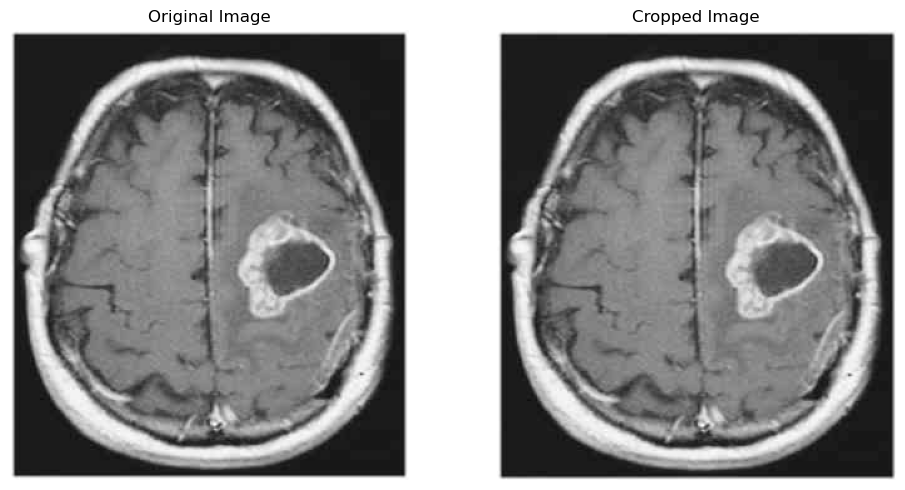

In [6]:
ex_img = cv2.imread('Brain_Tumor/yes/Y10.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

The following function takes two arguments, the first one is a list of directory paths for the folders pituitary, notumor, meningioma And glioma that contain the image data and the second argument is the image size, and for every image in directories and does the following: 
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (224, 224, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

In [20]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them in a memory-efficient way.
    Arguments:
        dir_list: list of strings representing file directories.
        image_size: tuple of (image_width, image_height).
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, 3).
        y: A numpy array with shape = (#_examples,).
    """
    X = []
    y = []

    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            file_path = f"{directory}/{filename}"
            
            # Load the image
            image = cv2.imread(file_path)
            if image is None:
                continue

            # Resize the image
            image = cv2.resize(image, (image_width, image_height), interpolation=cv2.INTER_CUBIC)

            # Normalize the image
            image = image / 255.0

            # Append the processed image
            X.append(image)

            # Assign labels based on folder name
            folder_name = directory.split('/')[-1].lower()
            if folder_name == 'glioma':
                y.append(0)
            elif folder_name == 'meningioma':
                y.append(1)
            elif folder_name == 'notumor':
                y.append(2)
            elif folder_name == 'pituitary':
                y.append(3)

    # Convert lists to numpy arrays
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int32)

    # Shuffle the data
    # X, y = shuffle(X, y, random_state=42)

    print(f'Number of examples: {len(X)}')
    print(f'X shape: {X.shape}')
    print(f'y shape: {y.shape}')

    return X, y


In [75]:
data = np.load("dataset.npz")
X = data["X"]
y = data["y"]


In [21]:
y = y.reshape(-1,1)

In [22]:
X,y = shuffle(X, y , random_state=42)

In [24]:
training_path = 'Training/'
glioma = training_path + 'glioma' 
meningioma = training_path + 'meningioma'
notumor = training_path + 'notumor'
pituitary = training_path + 'pituitary'
IMG_WIDTH, IMG_HEIGHT = (224, 224)
X, y = load_data([glioma,meningioma,notumor,pituitary], (IMG_WIDTH, IMG_HEIGHT))

Number of examples: 5712
X shape: (5712, 224, 224, 3)
y shape: (5712,)


In [32]:
training_path = 'Testing/'
glioma = training_path + 'glioma' 
meningioma = training_path + 'meningioma'
notumor = training_path + 'notumor'
pituitary = training_path + 'pituitary'
IMG_WIDTH, IMG_HEIGHT = (224, 224)
X_test, y_test = load_data([glioma,meningioma,notumor,pituitary], (IMG_WIDTH, IMG_HEIGHT))

Number of examples: 1311
X shape: (1311, 224, 224, 3)
y shape: (1311,)


In [26]:
y = y.reshape(-1,1)

In [28]:
X,y = shuffle(X, y , random_state=42)

In [30]:
np.savez_compressed("datasetesave5712_.npz", X=X, y=y)

In [28]:
def balance_data_downsampling(X_train, y_train):
    unique_classes, counts = np.unique(y_train, return_counts=True)
    min_count = np.min(counts)  # Find the smallest class count

    balanced_X, balanced_y = [], []

    for cls in unique_classes:
        indices = np.where(y_train == cls)[0]
        np.random.shuffle(indices)  
        selected_indices = indices[:min_count] 
        
        balanced_X.append(X_train[selected_indices])
        balanced_y.append(y_train[selected_indices])

    balanced_X = np.concatenate(balanced_X, axis=0)
    balanced_y = np.concatenate(balanced_y, axis=0)

    return balanced_X, balanced_y


In [29]:
balanced_X_train, balanced_y_train = balance_data_downsampling(X, y)
print("Balanced class distribution:", np.unique(balanced_y_train, return_counts=True))

Balanced class distribution: (array([0, 1, 2, 3]), array([2834, 2834, 2834, 2834], dtype=int64))


In [30]:
len(balanced_y_train)

11336

In [37]:
def split_images_and_labels(dataset):
    X_split = []
    y_split = []
    for image, label in dataset:
        X_split.append(image)
        y_split.append(label)
    return tf.concat(X_split, axis=0), tf.concat(y_split, axis=0)

In [35]:
balanced_X_train= np.array(balanced_X_train)
balanced_y_train = np.array(balanced_y_train)

In [36]:
balanced_y_train.reshape(balanced_y_train.shape[0],-1)

array([[0],
       [0],
       [0],
       ...,
       [3],
       [3],
       [3]])

In [39]:
balanced_X_train , balanced_y_train = shuffle(balanced_X_train , balanced_y_train , random_state=42)

In [41]:
balanced_y_train = balanced_y_train.reshape(-1,1)

In [43]:
balanced_y_train.shape

(11336, 1)

# As we see, we have 11336 images. Each images has a shape of (224, 224, 3)=(image_width, image_height, number_of_channels)

In [71]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    for label in [0,1,2,3]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "glioma" if label == 1 else "meningioma" if label == 2 else "notumor" if label == 3 else "pituitary"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

### Plot sample images:

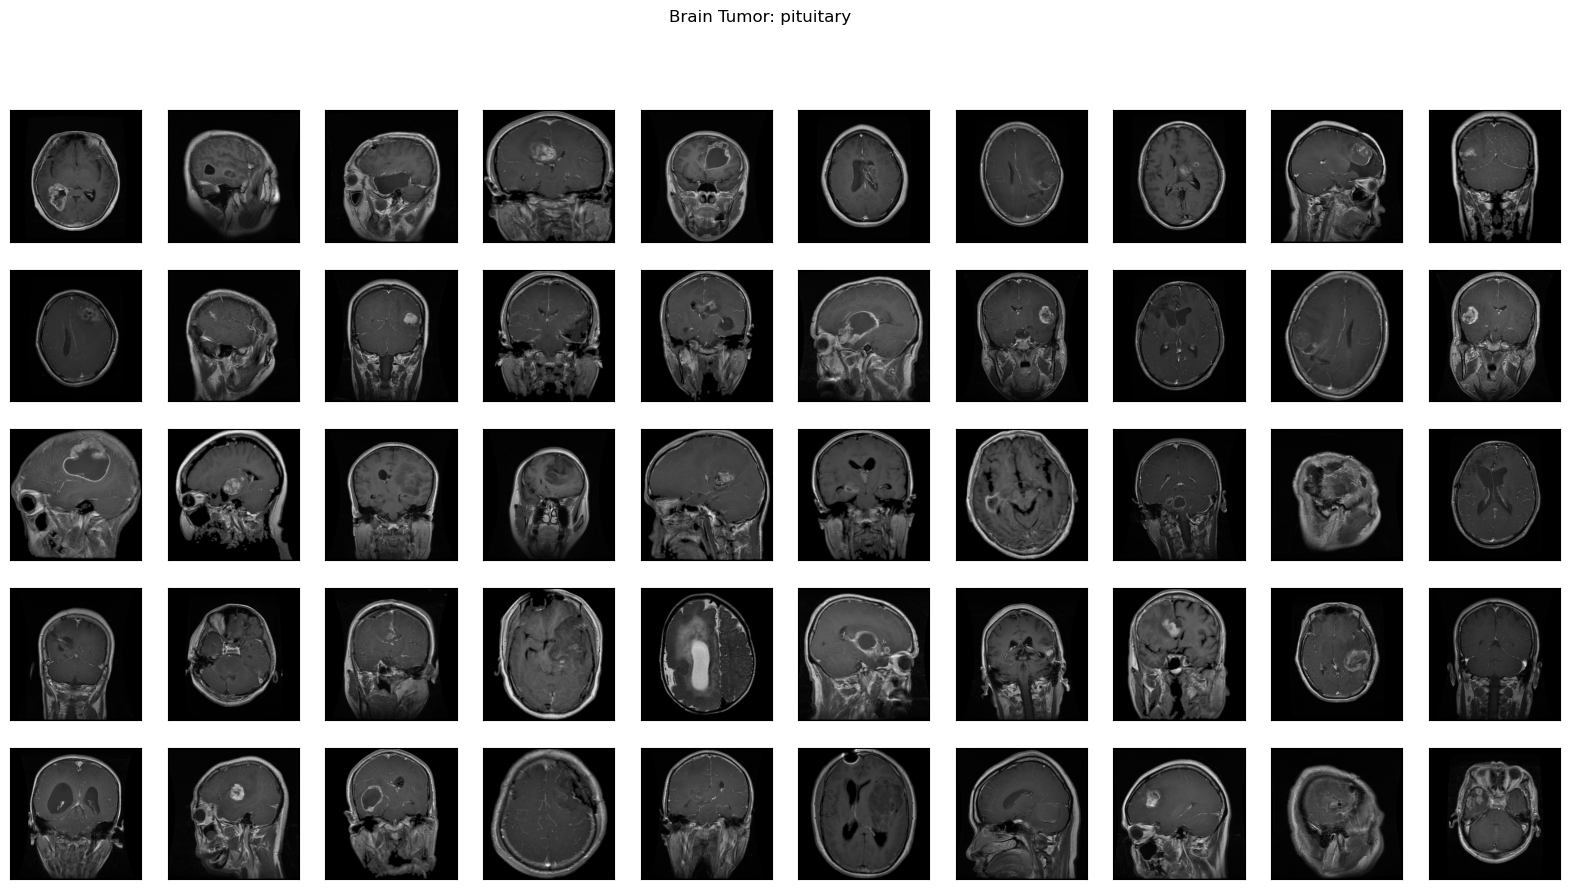

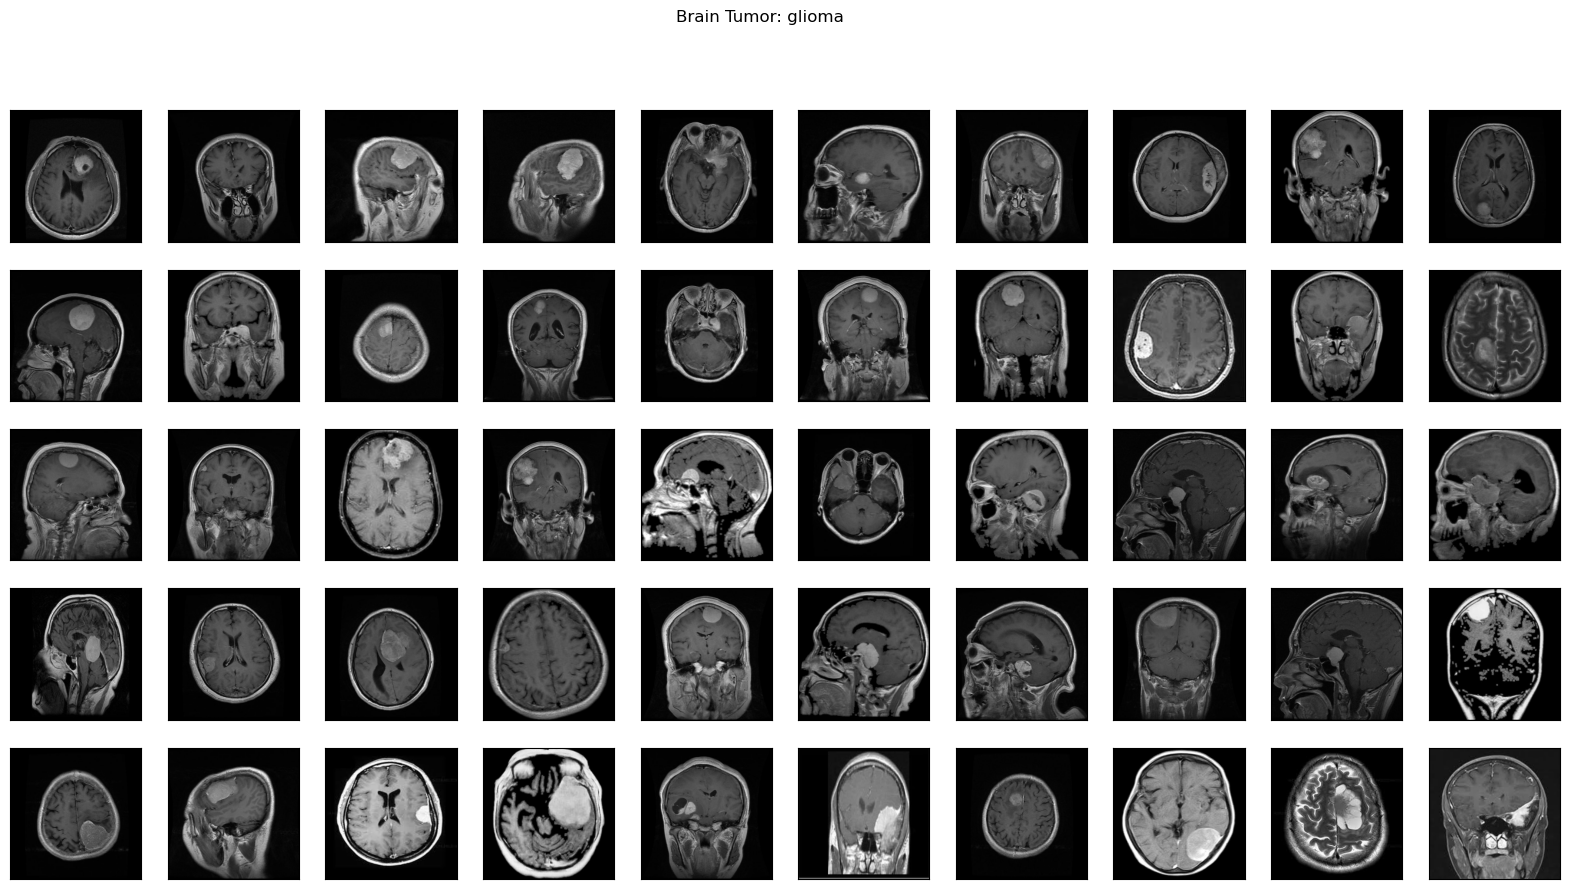

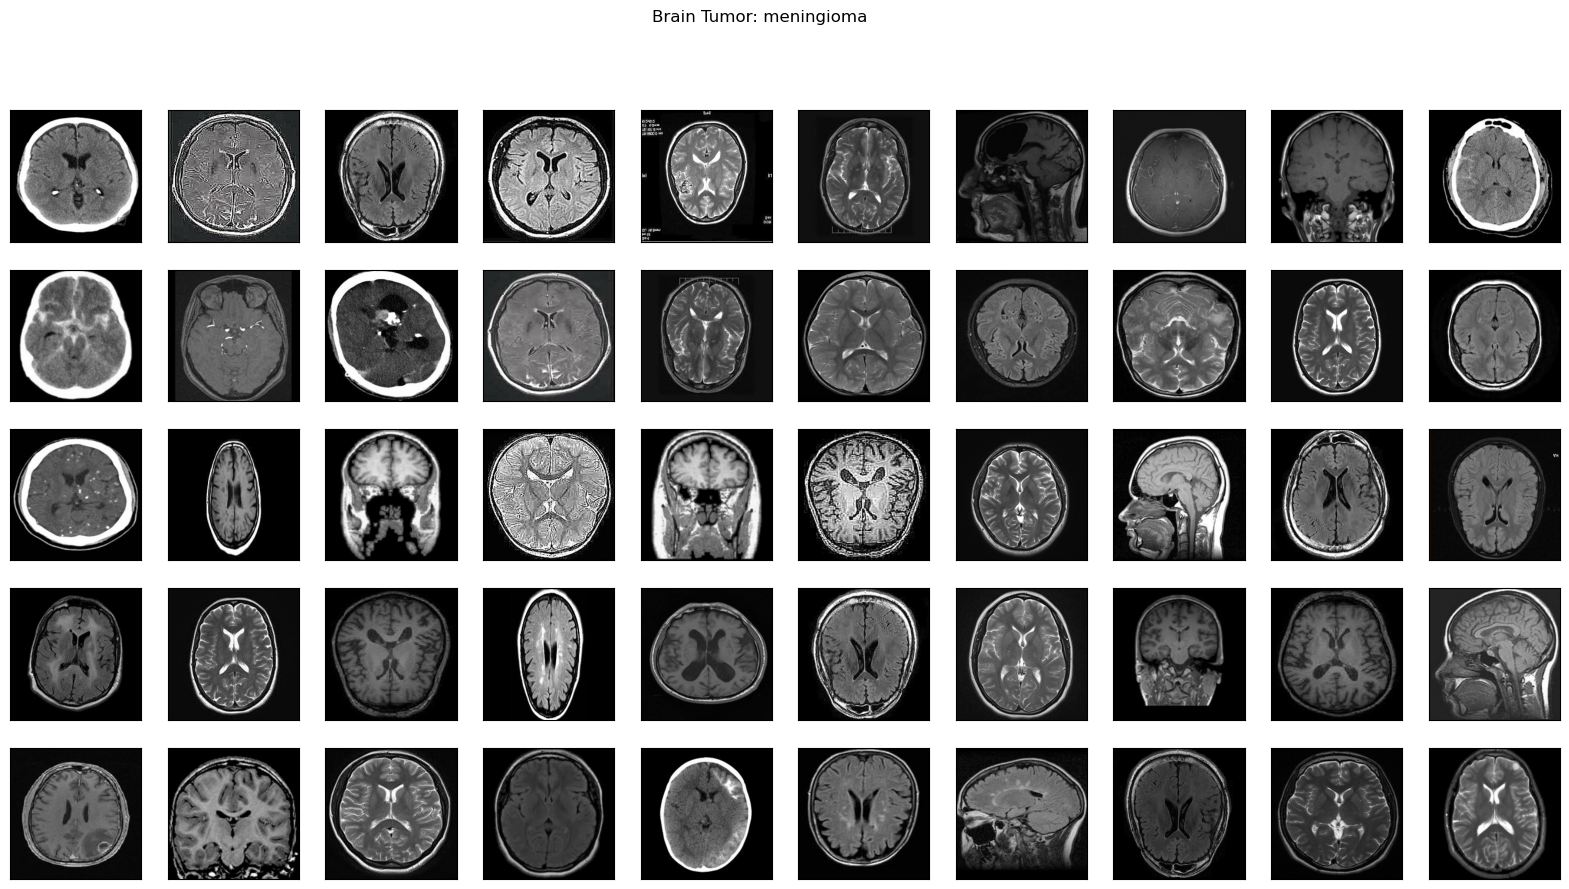

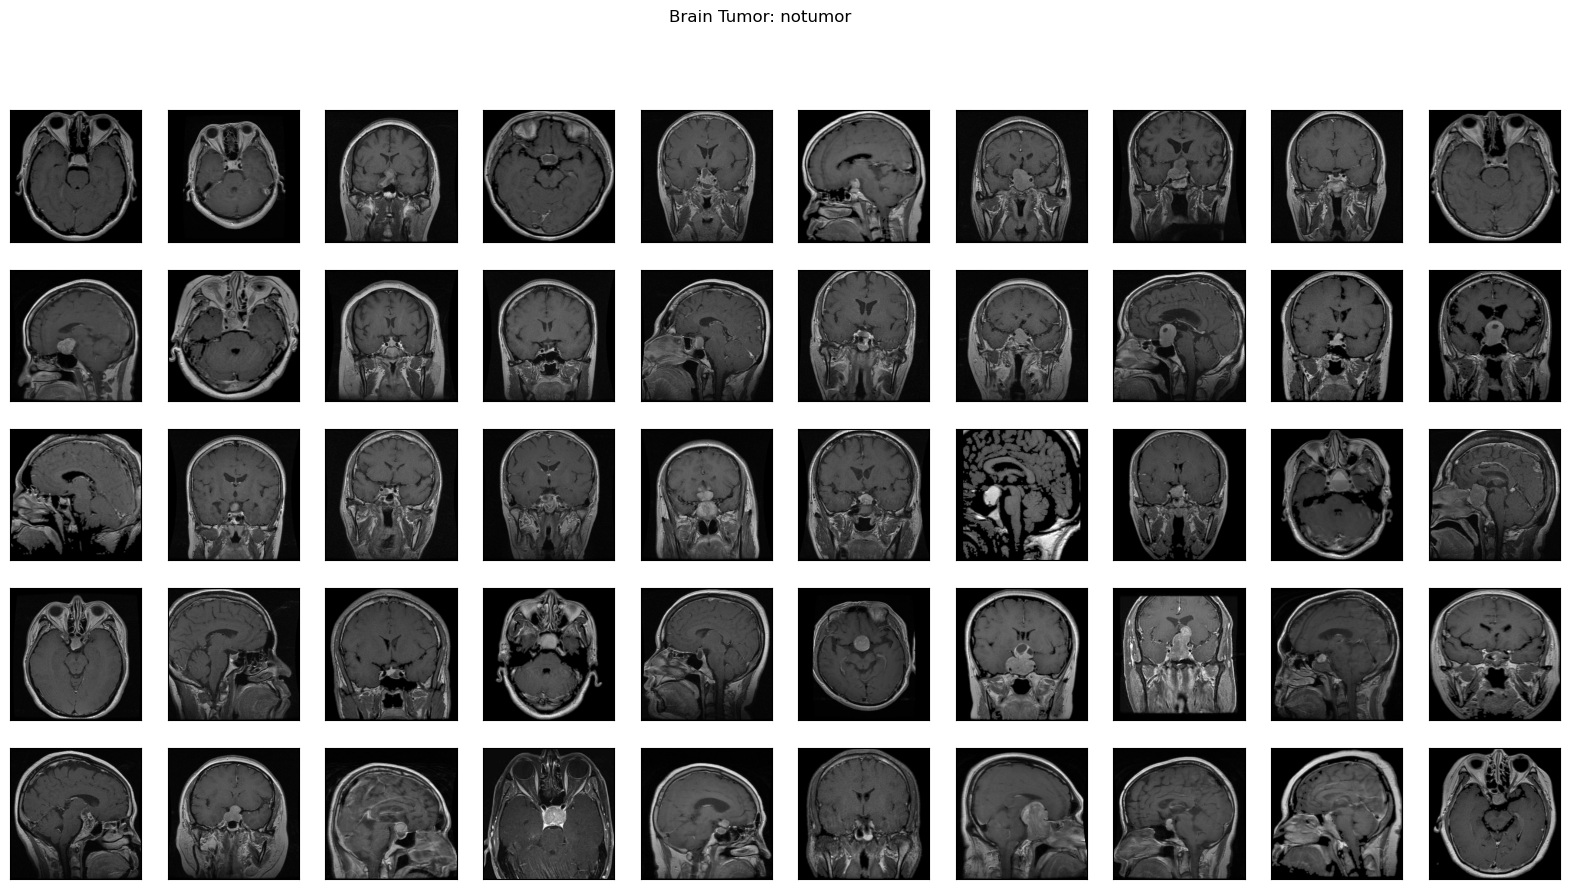

In [76]:
plot_sample_images(X, y)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [36]:
DATASET_SIZE = 5712
train_size = int(0.9 * DATASET_SIZE)
val_size = int(0.10 * DATASET_SIZE)
test_size = int(0.10 * DATASET_SIZE)

X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]
X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [58]:
np.savez_compressed('dataset_80-20.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, X_val =X_val, y_val = y_val)

In [5]:
dataset = np.load('dataset_80-20.npz')
X_train = dataset['X_train']
y_train = dataset['y_train']
X_val = dataset['X_val']
y_val = dataset['y_val']
X_test = dataset['X_test']
y_test = dataset['y_test']

In [38]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 5140
number of development examples = 571
number of test examples = 1
X_train shape: (5140, 224, 224, 3)
Y_train shape: (5140, 1)
X_val (dev) shape: (571, 224, 224, 3)
Y_val (dev) shape: (571, 1)
X_test shape: (1, 224, 224, 3)
Y_test shape: (1, 1)


In [40]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [42]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

Define the image shape:

In [45]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [47]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model.keras".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

## Train the model

In [127]:
# Create the input layer
combined_input = Input(shape=input_shape)

# Add base MobileNet model
x = base_model(combined_input)

# Global average pooling
x = Flatten()(x)
# Dense layer for classification with L2 regularization
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)

# Dropout layer for regularization


# Final output layer (binary classification for brain tumor: 'tumor' or 'no tumor')
output = Dense(4, activation='softmax')(x)  # Using sigmoid for multi classification
print(output) # [0.3 , 0.1  , .4 , 0.7]
# Create the model
model = Model(inputs=combined_input, outputs=output)

# Compile the model
model.compile(optimizer=Adamax(learning_rate = 0.0001), loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

<KerasTensor shape=(None, 4), dtype=float32, sparse=False, ragged=False, name=keras_tensor_313>


Let's train for a few more epochs:

In [69]:
start_time = time.time()
history=model.fit(x=X_train , y=y_train,batch_size = 32 , epochs = 20, validation_data=(X_val , y_val), callbacks=[tensorboard ,checkpoint])
model.save('MoblieNetV1.keras')
np.savez_compressed('model_history.npz', **history.history)
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 59s 363ms/step - accuracy: 0.9869 - loss: 0.1125 - val_accuracy: 0.9807 - val_loss: 0.1813
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9930 - loss: 0.0992 - val_accuracy: 0.9720 - val_loss: 0.1834
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9895 - loss: 0.1034 - val_accuracy: 0.9790 - val_loss: 0.1820
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 60s 375ms/step - accuracy: 0.9913 - loss: 0.1023 - val_accuracy: 0.9720 - val_loss: 0.1882
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 59s 367ms/step - accuracy: 0.9913 - loss: 0.0981 - val_accuracy: 0.9807 - val_loss: 0.1815
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 60s 370ms/step - accuracy: 0.9931 - loss: 0.0937 - val_accuracy: 0.9807 - val_loss: 0.1918
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9938 - loss: 0.0936 - val_accuracy: 0.9807 - val_loss: 0.1908
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 61s 379ms/step - accuracy: 0.9929 - loss: 0

## Plot Loss & Accuracy

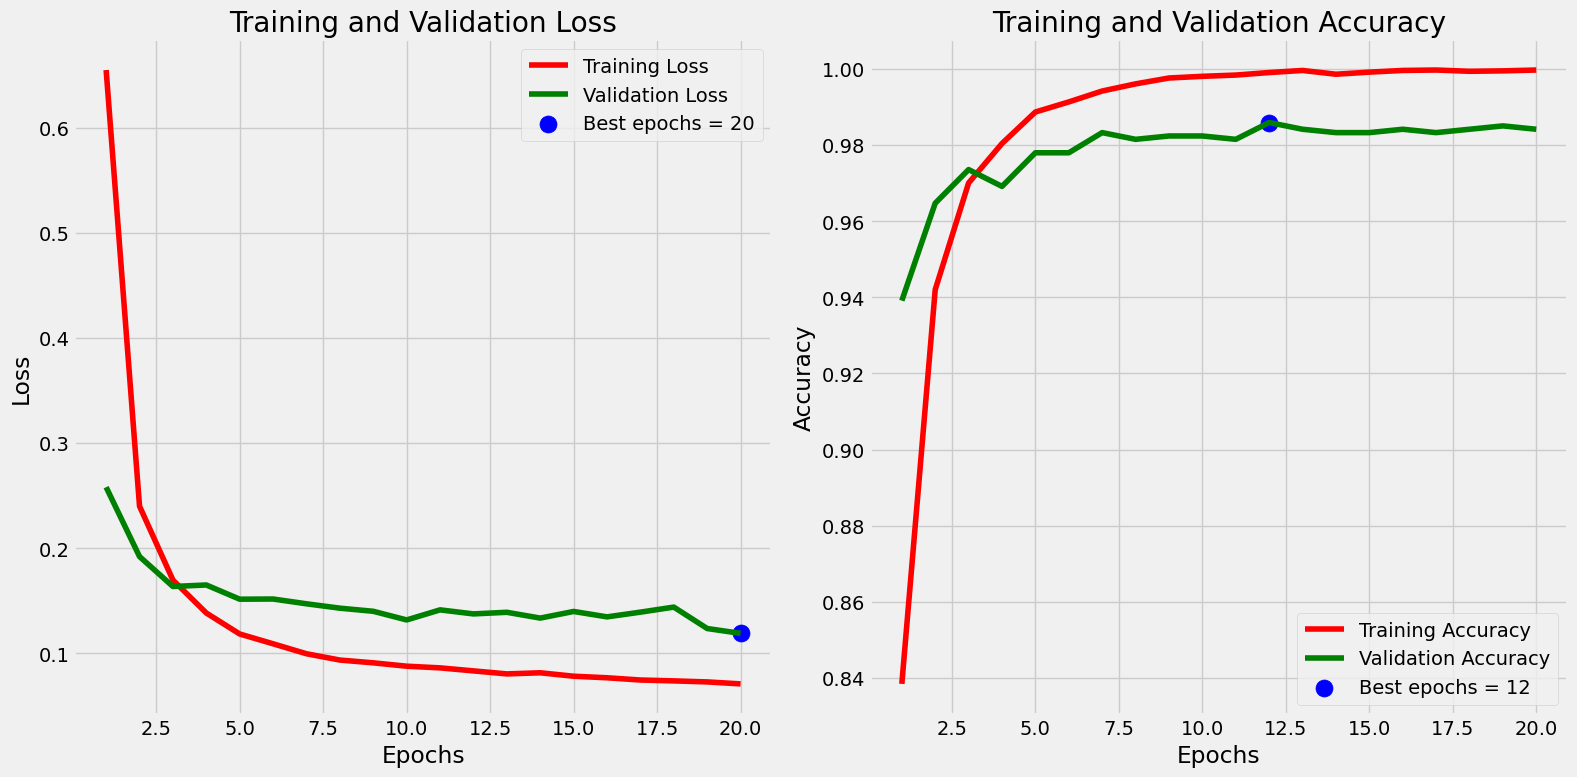

In [88]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

# Training history
plt.figure(figsize=(16,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue' , label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue' , label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('visulize_fr_MLP')
plt.legend()
plt.savefig('Brain_tumor_mob_net')
plt.tight_layout()
plt.show()

# Results

Let's experiment with the best model (the one with the best validation accuracy):

### Load the best model

In [30]:
best_model = keras.models.load_model(filepath='models/cnn-parameters-improvement-20-0.98.model.keras')

In [31]:
best_model.metrics_names

['loss', 'compile_metrics']

Evaluate the best model on the testing data:

In [85]:
loss, acc = best_model.evaluate(x=X_t, y=y_t)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.0000e+00 - loss: 2.7684


### Accuracy of the best model on the testing data:

In [88]:
print (f"Test Loss = {round(loss , 2)}")
print (f"Test Accuracy = {round(acc * 100, 2)}")

Test Loss = 2.77
Test Accuracy = 0.0


### F1 score for the best model on the testing data:

In [91]:
y_test_prob = best_model.predict(X_t)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [93]:
y_pred = np.argmax(y_test_prob , axis=1)
y_pred

array([2])

In [94]:
f1score = f1_score(y_test_filtered ,np.argmax(y_test_prob , axis=1), average='micro')
predicted_labels=np.argmax(y_test_prob , axis = 1)
print(f"F1 score: {f1score}")

F1 score: 0.9932203389830508


In [96]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [98]:
print("\nClassification Report:\n", classification_report(y_test_filtered, y_pred , target_names=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']))


Classification Report:
               precision    recall  f1-score   support

      Glioma       1.00      0.97      0.99       208
  Meningioma       0.98      1.00      0.99       239
    No Tumor       1.00      1.00      1.00       236
   Pituitary       1.00      1.00      1.00       202

    accuracy                           0.99       885
   macro avg       0.99      0.99      0.99       885
weighted avg       0.99      0.99      0.99       885



In [61]:
recall

0.9959345802872548

In [63]:
predicted_labels=np.argmax(y_test_prob , axis=1)

Let's also find the f1 score on the validation data:

In [66]:
predicted_labels=np.argmax(y_test_prob , axis=1)

In [70]:
cm = confusion_matrix(y, predicted_labels)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1281    8    0    0]
 [  11 1576    2    0]
 [   0    1  810    0]
 [   1    0    0 1559]]


In [74]:
report = classification_report(y, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1289
           1       0.99      0.99      0.99      1589
           2       1.00      1.00      1.00       811
           3       1.00      1.00      1.00      1560

    accuracy                           1.00      5249
   macro avg       1.00      1.00      1.00      5249
weighted avg       1.00      1.00      1.00      5249



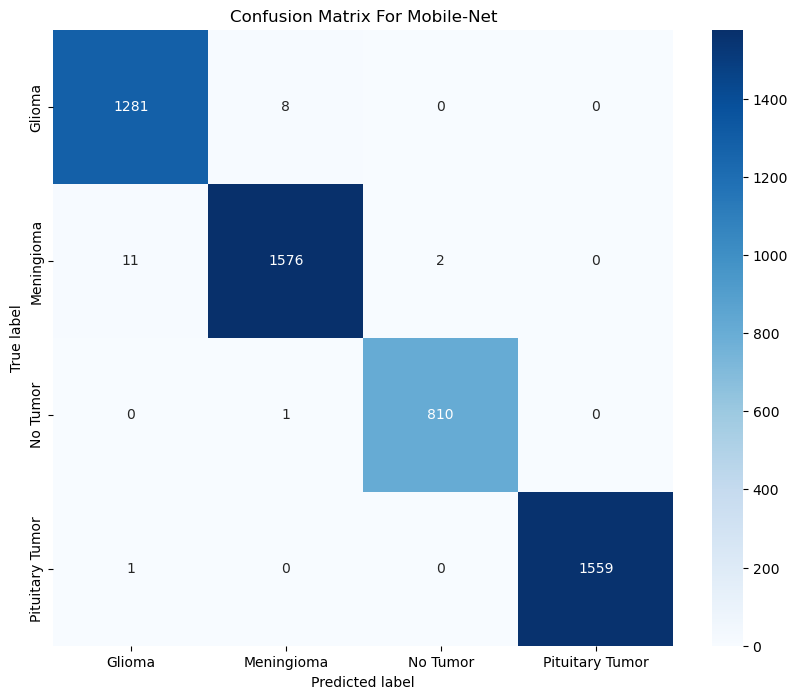

In [76]:
import seaborn as sns

class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary Tumor']

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix For Mobile-Net")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.savefig('confusion matrix for mobile-net.png')
plt.show()


# Conclusion:

#### Now, the model detects brain tumor with:<br>
**99.21%** accuracy on the **test set**.<br>
**99.20%** f1 score on the **test set**.<br>
These resutls are very good considering that the data is balanced.

**Performance Table:**

| <!-- -->  | Validation set | Test set |
| --------- | -------------- | -------- |
| Accuracy  | 98.60%            | 99.21%      |
| F1 score  | 98.61%           | 99.20%    |